In [1]:
using Oceananigans
using NCDatasets
using Printf
using CairoMakie
using Oceananigans.Fields
using Oceananigans.AbstractOperations: volume
using NaNStatistics

In [2]:
using TopographicHorizontalConvection: HorizontalConvectionSimulation

In [3]:
#function to find  χ same method used for turbulent and diffusive
function find_χ(ds)
    x = ds["xC"][4+1:end-4]; Nx = length(x);
    z = ds["zC"][4+1:end-4]; Nz = length(z);
    time = ds["time"][:];
    Δx = reshape(diff(ds["xF"])[4+1:end-4], Nx,1,1);
    Δz = reshape(diff(ds["zF"])[4+1:end-4], 1,1,Nz);
    ΔA = Δx; #flat in y -- 2 dimensional
    ΔV = ΔA.*Δz;
    χ = zeros(size(time,1));
    for n in 1:size(time, 1)
        χt = ds["chi"][4+1:end-4, 1, 4+1:end-4, n]
        wet = χt.!=0.
        χt[.!wet] .= NaN
        χ[n] = nansum(
            χt .*
            ΔV,
            dims=(1,2,3)
        )[1,1,1]
    end
    return χ
    
    
end

find_χ (generic function with 1 method)

In [142]:
#input for turbulent χ's
prefix = "/Users/hfdrake/code/HorizontalConvection/output/turbulent_h0.6_Ra";
suffix = "_buoyancy.nc";

ds_array = [NCDataset(string(prefix, "100000.0", suffix)),
            NCDataset(string(prefix, "1.0e6", suffix)),
            NCDataset(string(prefix, "1.0e7", suffix))];
            #NCDataset(string(prefix, "1.0e8", suffix))];




χ_array = [find_χ(ds) for ds in ds_array];



In [143]:
#turbulent chi arrays below

χ_turb_1e5 = χ_array[1];
χ_turb_1e6 = χ_array[2];
χ_turb_1e7 = χ_array[3];
χ_turb_1e8 = χ_array[4];

In [144]:
#now the corresponding diffusive χ's
prefix_diff = "/Users/hfdrake/code/HorizontalConvection/output/diffusive_h0.6_Ra";
suffix_diff = "_buoyancy.nc";

ds_array_diff = [NCDataset(string(prefix_diff, "100000.0", suffix_diff)),
            NCDataset(string(prefix_diff, "1.0e6", suffix_diff)),
            NCDataset(string(prefix_diff, "1.0e7", suffix_diff)),
            NCDataset(string(prefix_diff, "1.0e8", suffix_diff))];

χ_array_diff = [find_χ(ds) for ds in ds_array_diff];

In [145]:
χ_diff_1e5 = χ_array_diff[1];
χ_diff_1e6 = χ_array_diff[2];
χ_diff_1e7 = χ_array_diff[3];
χ_diff_1e8 = χ_array_diff[4];

In [146]:
Nusselt_1e5 = χ_turb_1e5 ./ χ_diff_1e5;
Nusselt_1e6 = χ_turb_1e6 ./ χ_diff_1e6;
Nusselt_1e7 = χ_turb_1e7 ./ χ_diff_1e7;
Nusselt_1e8 = χ_turb_1e8 ./ χ_diff_1e8;



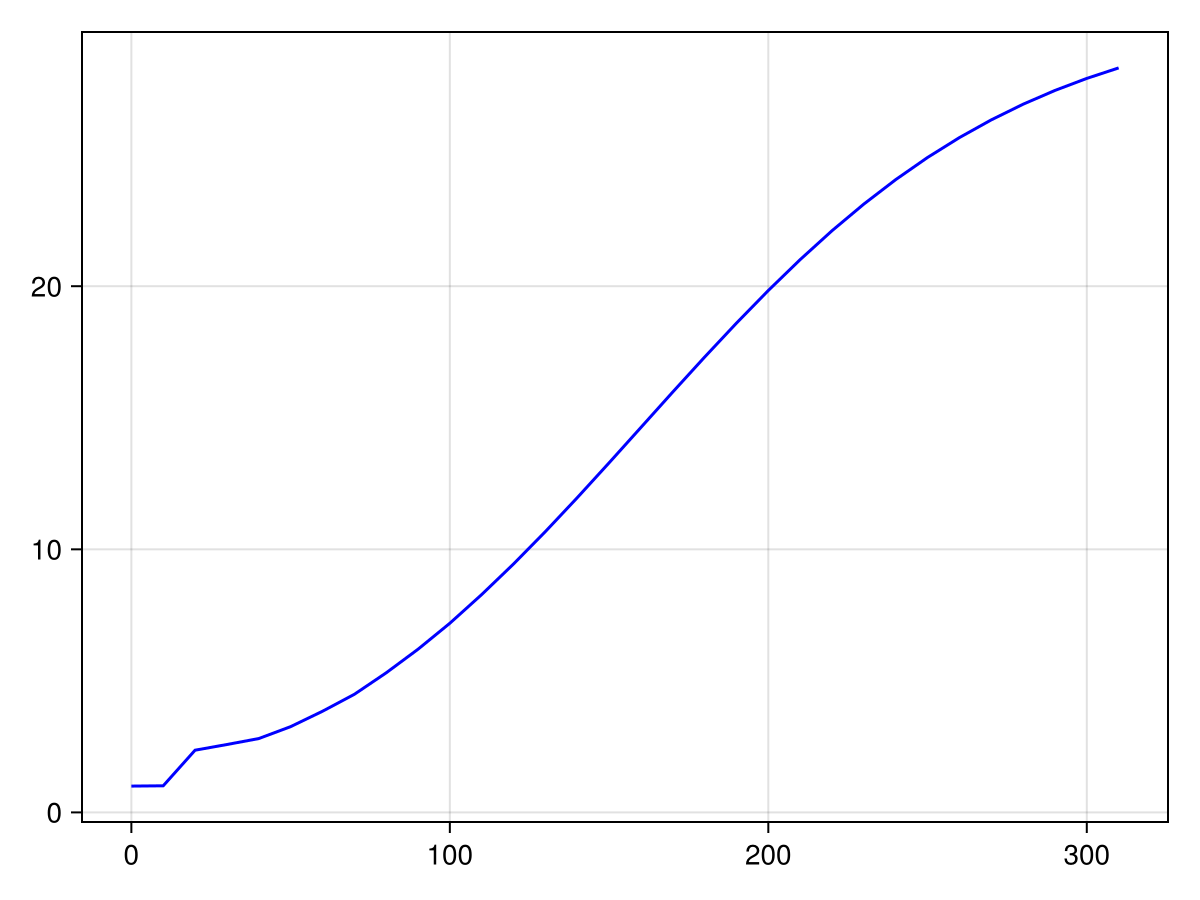

In [147]:
lines(ds_array[1]["time"][:], Nusselt_1e5, label="Ra = 1e5", color=:blue)

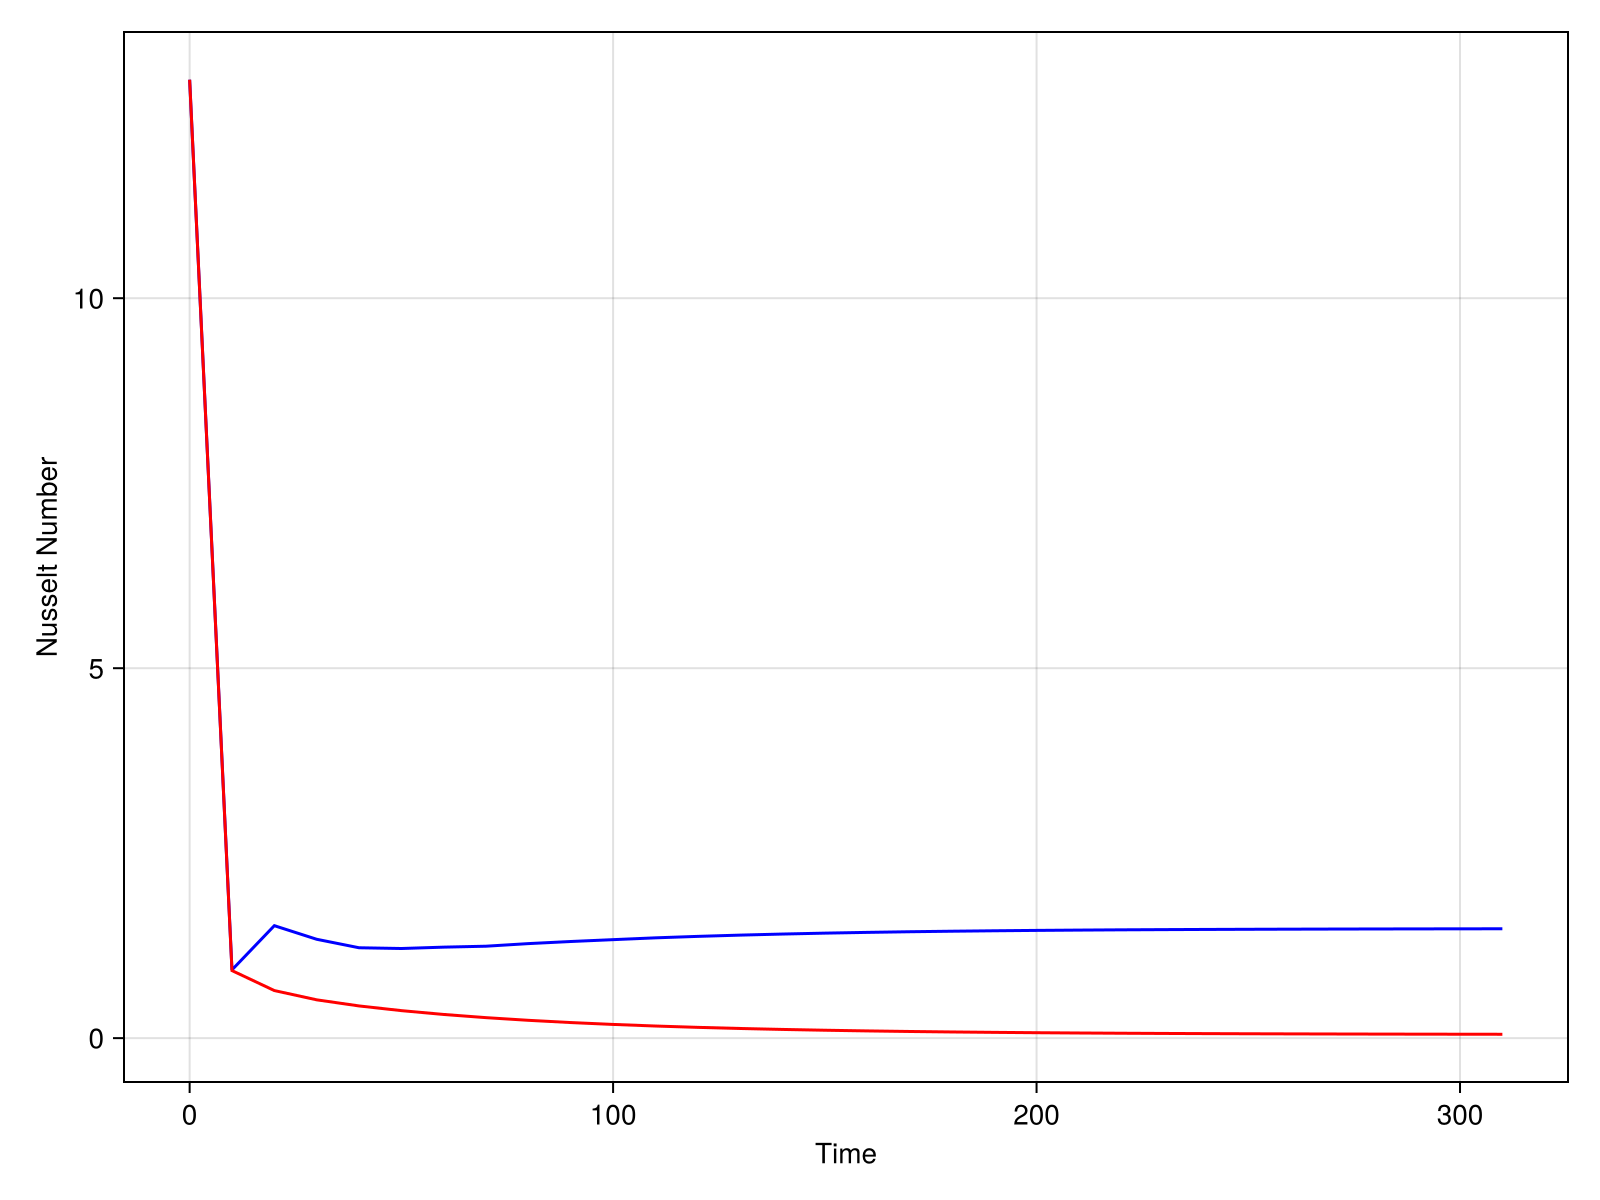

In [148]:
fig = Figure(resolution = (800, 600))
ax = Axis(fig[1, 1], xlabel = "Time", ylabel = "Nusselt Number")
lines!(ax, ds_array[1]["time"][:], χ_turb_1e5, label="Ra = 1e7", color=:blue)
lines!(ax, ds_array[1]["time"][:], χ_diff_1e5, label="Ra = 1e7", color=:red)
fig

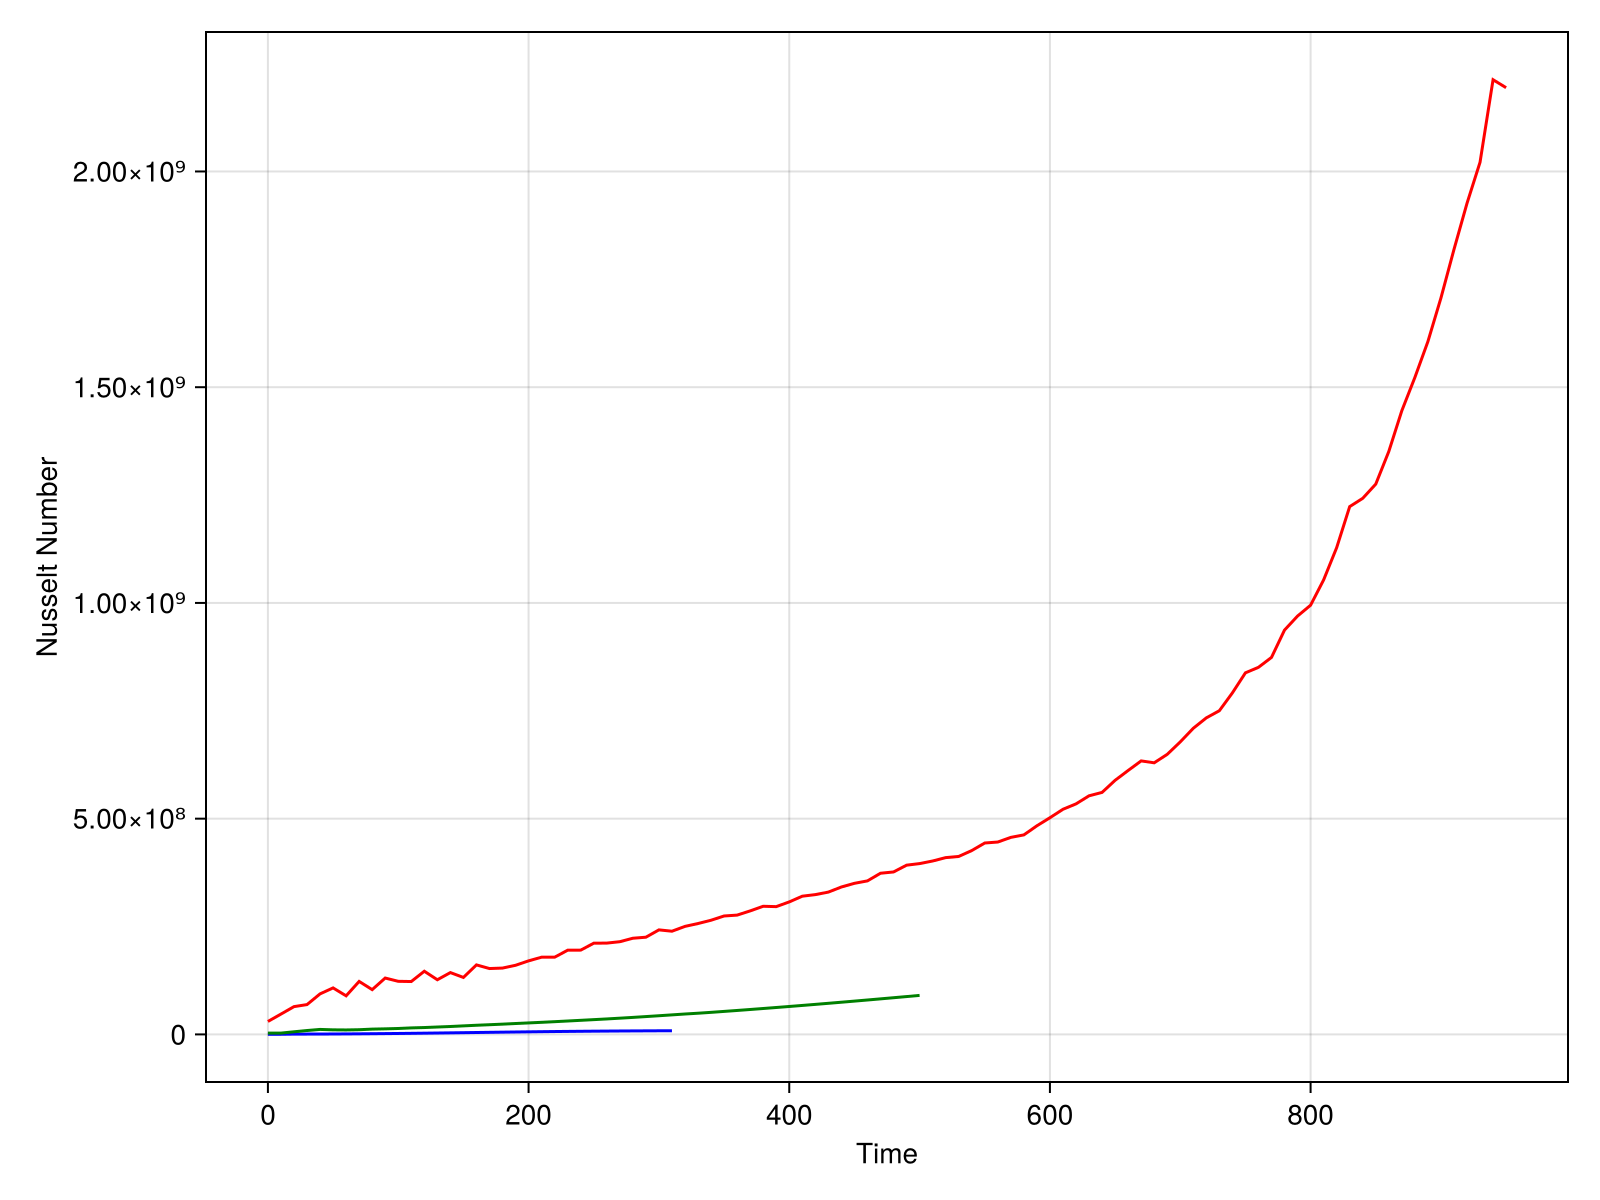

In [133]:
fig = Figure(resolution = (800, 600))
ax = Axis(fig[1, 1], xlabel = "Time", ylabel = "Nusselt Number")
lines!(ds_array[1]["time"][:], Nusselt_1e5, label="Ra = 1e5", color=:blue)
lines!(ds_array[2]["time"][:], Nusselt_1e6, label="Ra = 1e6", color=:green)
lines!(ds_array[3]["time"][:], Nusselt_1e7, label="Ra = 1e7", color=:red)
#lines!(ds_array[4]["time"][:], Nusselt_1e8, label="Ra = 1e8", color=:purple)

fig

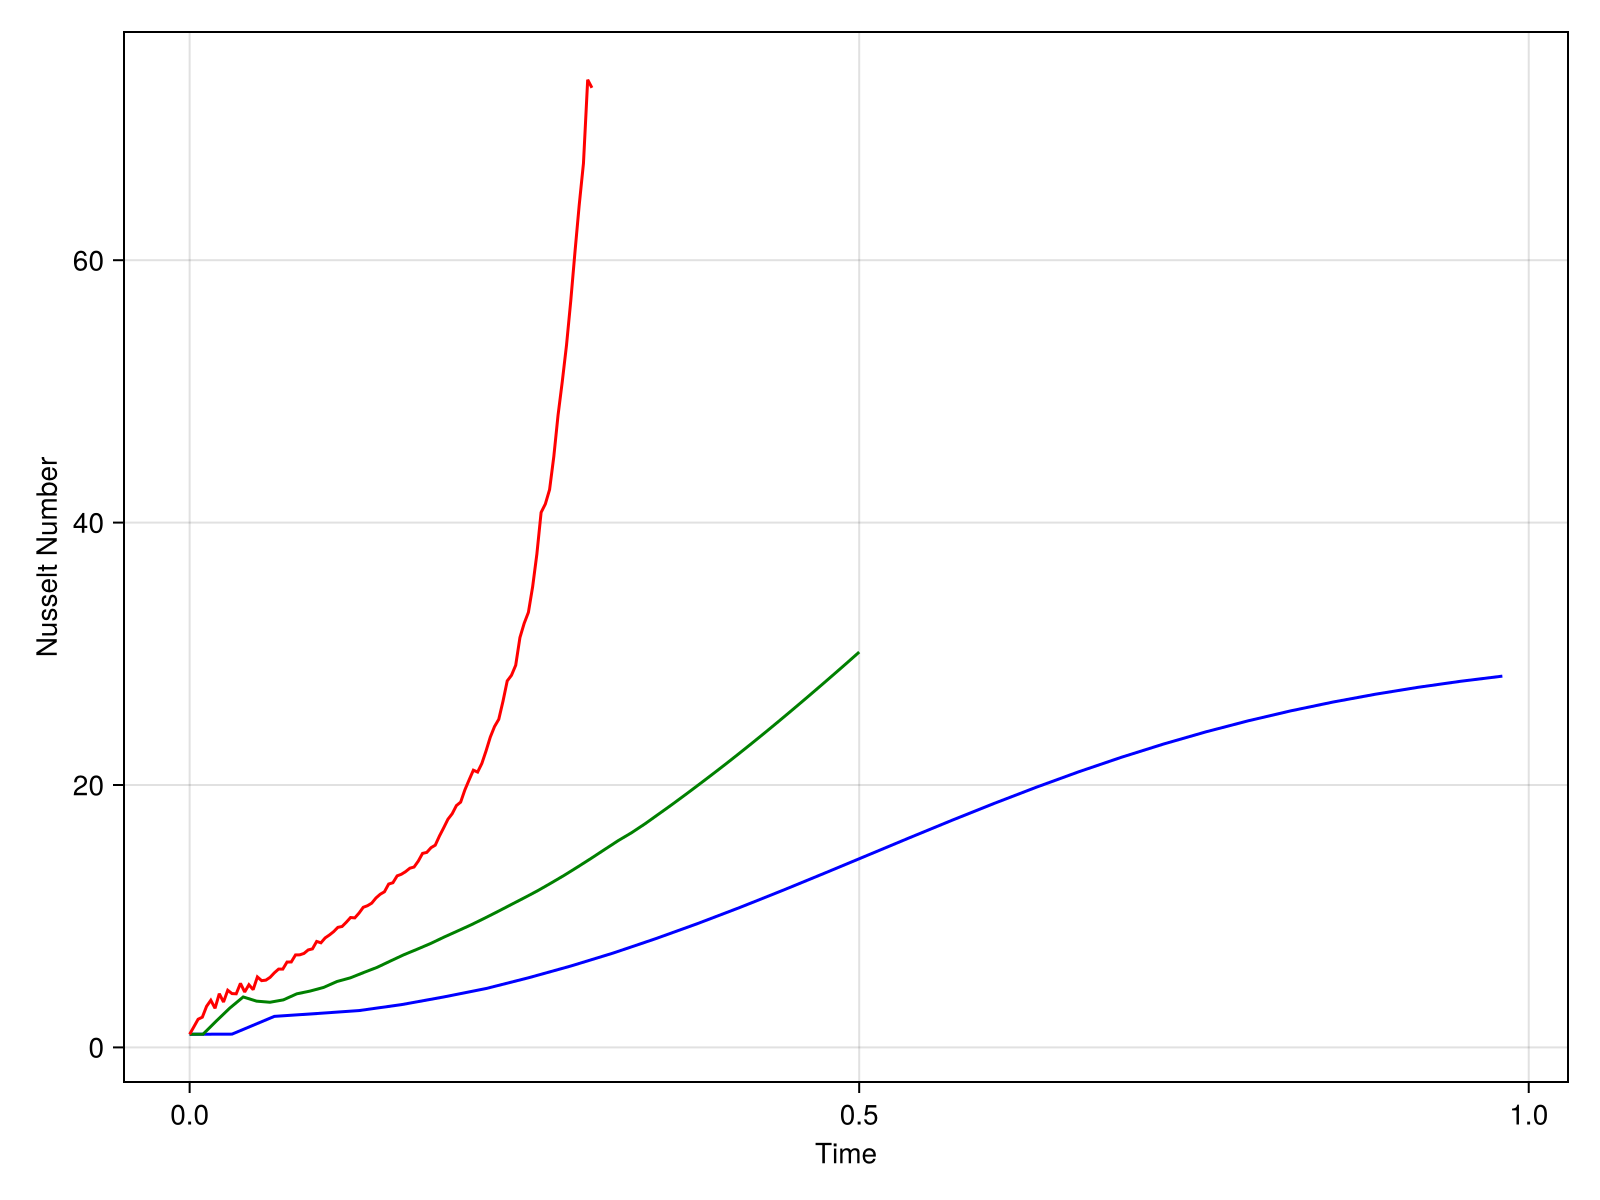

In [127]:
#normalize time arrays by multiplying by 1/sqrt(Ra) to compare the time scales of the simulations

time_1e5 = ds_array[1]["time"][:].*1/sqrt(1e5);
time_1e6 = ds_array[2]["time"][:].*1/sqrt(1e6);
time_1e7 = ds_array[3]["time"][:].*1/sqrt(1e7);
time_1e8 = ds_array[4]["time"][:].*1/sqrt(1e8);

times = [time_1e5, time_1e6, time_1e7, time_1e8];

#plotting the normalized time arrays
fig = Figure(resolution = (800, 600))
ax = Axis(fig[1, 1], xlabel = "Time", ylabel = "Nusselt Number")
lines!(time_1e5, Nusselt_1e5, label="Ra = 1e5", color=:blue)
lines!(time_1e6, Nusselt_1e6, label="Ra = 1e6", color=:green)
lines!(time_1e7, Nusselt_1e7, label="Ra = 1e7", color=:red)
#lines!(time_1e8, Nusselt_1e8, label="Ra = 1e8", color=:purple)
fig


In [ ]:
#bottom buoyancy plots

#average of b(z=-h) over x from rocha improved bounds paper fig 2

In [149]:
ds_array[2]["time"][:]

51-element Vector{Float64}:
   0.0
  10.0
  20.0
  30.0
  40.0
  50.0
  60.0
  70.0
  80.0
  90.0
   ⋮
 420.0
 430.0
 440.0
 450.0
 460.0
 470.0
 480.0
 490.0
 500.0